<a href="https://colab.research.google.com/github/demolakstate/anomaly_detection_sport_video/blob/main/conv_lstm_kackle_study_kdd_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
  
# -*- coding: utf-8 -*-
"""conv_lstm_kackle_study_v2
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/1vw2RPDDU-02Hst2Ef4N0s_zkqGdBX98q
# Next-Frame Video Prediction with Convolutional LSTMs
**Author:** [Amogh Joshi](https://github.com/amogh7joshi)<br>
**Date created:** 2021/06/02<br>
**Last modified:** 2021/06/05<br>
**Description:** How to build and train a convolutional LSTM model for next-frame video prediction.
## Introduction
The
[Convolutional LSTM](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf)
architectures bring together time series processing and computer vision by
introducing a convolutional recurrent cell in a LSTM layer. In this example, we will explore the
Convolutional LSTM model in an application to next-frame prediction, the process
of predicting what video frames come next given a series of past frames.
## Setup
"""

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import cv2

from google.colab.patches import cv2_imshow

import os

from sklearn.model_selection import train_test_split

In [23]:
"""##Define hyperparameters"""

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 768#3072#768#1024
IMG_SIZE = 128



"""## Dataset Construction
For this example, we will be using the
[Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/)
dataset.
We will download the dataset and then construct and
preprocess training and validation sets.
For next-frame prediction, our model will be using a previous frame,
which we'll call `f_n`, to predict a new frame, called `f_(n + 1)`.
To allow the model to create these predictions, we'll need to process
the data such that we have "shifted" inputs and outputs, where the
input data is frame `x_n`, being used to predict frame `y_(n + 1)`.
##Data collection
"""


'## Dataset Construction\nFor this example, we will be using the\n[Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/)\ndataset.\nWe will download the dataset and then construct and\npreprocess training and validation sets.\nFor next-frame prediction, our model will be using a previous frame,\nwhich we\'ll call `f_n`, to predict a new frame, called `f_(n + 1)`.\nTo allow the model to create these predictions, we\'ll need to process\nthe data such that we have "shifted" inputs and outputs, where the\ninput data is frame `x_n`, being used to predict frame `y_(n + 1)`.\n##Data collection\n'

In [24]:
#Connect to drive
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            #frame = crop_center(frame)
            # resize frames
            frame = cv2.resize(frame, (128,128))
            frame = frame[:, :, [2, 1, 0]]
            #print(f'frame shape: {frame.shape}')
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

#frames = load_video('/content/gdrive/MyDrive/ksutackle_dataset/risky_7.mp4', 20)

#frames.shape



In [26]:
#Let extract features
def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(weights="imagenet",include_top=False,pooling="avg",
                        input_shape=(IMG_SIZE, IMG_SIZE, 3), )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    # Add a dense layer
    outputs = layers.Dense(768)(outputs)


    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()

In [27]:

for layer in feature_extractor.layers[:-1]:
  layer.trainable = False

In [28]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                 

In [29]:
def prepare_all_videos(root_dir, frames_all=[]):
    
    video_paths = os.listdir(root_dir)
    labels = [video_path.split('_')[0] for video_path in video_paths]
    num_samples = len(labels)
    
    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Call visualization here

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[:20]
        frames = frames[None, ...]
         # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :] )
                else:
                    temp_frame_features[i, j, :] = 0.0
        frame_features[idx,] = temp_frame_features.squeeze()

    print(frame_features.shape)

    return frame_features

        #frames_all.append(frames)

    #return np.array(frames_all)


In [30]:

cap = cv2.VideoCapture('/content/gdrive/MyDrive/ksutackle_dataset/risky_7.mp4')
ret, frame = cap.read()
i = 0

while ret:
  # try:
  #   ret, frame = cap.read()
  #   if not ret:
  #     break
    #cv2_imshow(frame)
    #frame = crop_center(frame)
    #cv2.imwrite(f'frame_{i}.jpg', frame)
    ret, frame = cap.read()
    i += 1
    #cv2_imshow(frame)
    #frame = frame[:,:,[1,2,0]]
    #print(frame.shape)
    #cv2_imshow(frame)


  # finally:
  #   cap.release()

In [31]:
try:
    data = np.load("data_conv_lstm.npy")
    print("Successfully loaded data from disk")
except FileNotFoundError:
    print("Dataset not available on disk, preparing a new one...")
    #data = prepare_all_videos('../../ksutackle_dataset_108')
    data = prepare_all_videos('/content/gdrive/MyDrive/ksutackle_dataset')
    np.save("data_conv_lstm.npy", data)
    #np.save("labels.npy", labels)

train_data_all, test_data  = train_test_split(data, test_size=0.30, random_state=42)
#train_data, val_data, train_labels, val_labels = train_test_split(train_data_all, train_labels_all, test_size=0.20, random_state=45)
print(f"Frame features in train set: {train_data_all.shape}")


Successfully loaded data from disk
Frame features in train set: (75, 20, 768)


In [32]:

# Normalize the data to the 0-1 range.
train_dataset = train_data_all / 255
val_dataset = test_data / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    # x = data[:, 0 : data.shape[1] - 1, :, :]
    # y = data[:, 1 : data.shape[1], :, :]
    x = data[:, 0 : data.shape[1] - 1, :]
    y = data[:, 1 : data.shape[1], :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (75, 19, 768), (75, 19, 768)
Validation Dataset Shapes: (33, 19, 768), (33, 19, 768)


In [33]:
x_train = layers.Reshape((-1,16,16,3))(x_train)
y_train = layers.Reshape((-1,16,16,3))(y_train)

x_val = layers.Reshape((-1,16,16,3))(x_val)
y_val = layers.Reshape((-1,16,16,3))(y_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Displaying frames for example 62.


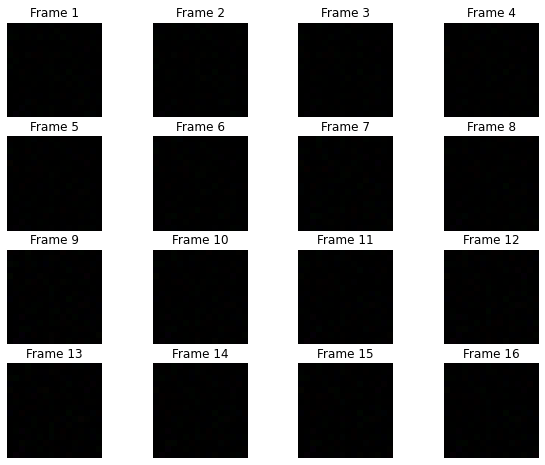

'## Model Construction\nTo build a Convolutional LSTM model, we will use the\n`ConvLSTM2D` layer, which will accept inputs of shape\n`(batch_size, num_frames, width, height, channels)`, and return\na prediction movie of the same shape.\n'

In [34]:

"""## Data Visualization
Our data consists of sequences of frames, each of which
are used to predict the upcoming frame. Let's take a look
at some of these sequential frames.
"""

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 4, figsize=(10, 8))
#axes -= 1

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    #ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.imshow(y_train[data_choice][idx], cmap="brg")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

"""## Model Construction
To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.
"""

In [35]:

# data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),tf.keras.layers.RandomRotation(0.2),])
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# # Create the base model from the pre-trained model MobileNet V2
# IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# #image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(x_train[0])
# print(feature_batch.shape)

In [36]:

# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

#x = layers.Reshape((-1,16,16,3))(inp)

print(inp.shape)

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=3, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

print(inp.shape)

(None, None, 16, 16, 3)
(None, None, 16, 16, 3)


In [41]:
# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)

model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

"""## Model Training
With our model and data constructed, we can now train the model.
"""

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)


model.save('model_conv_lstm_v2.h5')
"""## Frame Prediction Visualizations
With our model now constructed and trained, we can generate
some example frame predictions based on a new video."""

Epoch 1/20
15/15 [==============================] - 68s 4s/step - loss: -37180.0625 - val_loss: -55.9850 - lr: 0.0010
Epoch 2/20
15/15 [==============================] - 58s 4s/step - loss: -552.2786 - val_loss: -20.6555 - lr: 0.0010
Epoch 3/20
15/15 [==============================] - 58s 4s/step - loss: -91.3224 - val_loss: -22.0253 - lr: 0.0010
Epoch 4/20
15/15 [==============================] - 58s 4s/step - loss: -84.3361 - val_loss: -27.0355 - lr: 0.0010
Epoch 5/20
15/15 [==============================] - 58s 4s/step - loss: -66.6039 - val_loss: -29.0198 - lr: 0.0010
Epoch 6/20
15/15 [==============================] - 58s 4s/step - loss: -50.7041 - val_loss: -29.0928 - lr: 0.0010
Epoch 7/20
15/15 [==============================] - 58s 4s/step - loss: -46.9788 - val_loss: -26.6771 - lr: 1.0000e-04
Epoch 8/20
15/15 [==============================] - 58s 4s/step - loss: -46.8092 - val_loss: -26.8609 - lr: 1.0000e-04
Epoch 9/20
15/15 [==============================] - 59s 4s/step - lo

'## Frame Prediction Visualizations\nWith our model now constructed and trained, we can generate\nsome example frame predictions based on a new video.'

In [42]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['accuracy'], label='training_accuracy')
# plt.plot(history.history['val_accuracy'], label='validation_accuracy')
# #plt.plot(history.history['loss'], label='training_loss')
# #plt.plot(history.history['val_loss'], label='validation_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# #plt.title('Accuracy')
# plt.legend()
# plt.imshow()
# plt.savefig('plt_accuracy.png', dpi=300, bbox_inches='tight')



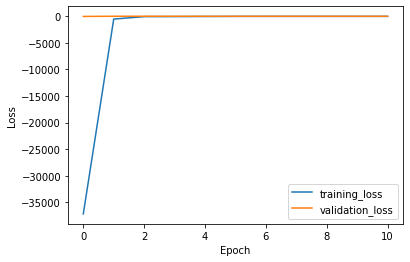

In [43]:

#plt.plot(history.history['accuracy'], label='training_accuracy')
#plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.title('Accuracy')
plt.legend()
#plt.imshow()
plt.savefig('plt_loss.png', dpi=300, bbox_inches='tight')